In [8]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -197.350
Method:                       css-mle   S.D. of innovations             66.436
Date:                Wed, 06 Oct 2021   AIC                            408.699
Time:                        12:48:30   BIC                            419.587
Sample:                    02-01-1991   HQIC                           412.458
                         - 12-01-1993                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.4256      3.774      3.292      0.003       5.028      19.823
ar.L1.D.Sales    -1.0850      0.188     -5.764      0.000      -1.454      -0.716
ar.L2.D.Sales    -0.6688      0.283     

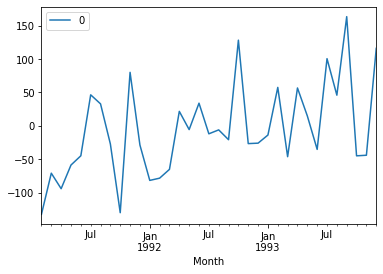

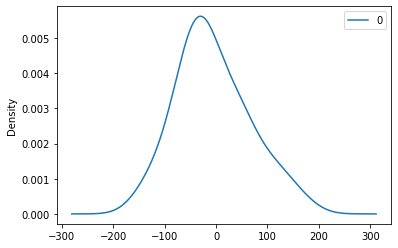

                0
count   35.000000
mean    -5.569205
std     70.272669
min   -132.525589
25%    -45.563708
50%    -20.763430
75%     39.933248
max    163.552236


In [5]:
def parser(x):
  return datetime.strptime('199' +x, '%Y-%m')

series = read_csv('/content/drive/MyDrive/Colab Notebooks/성신신성/jj/data/sales.csv', 
                  header = 0, 
                  parse_dates = [0],
                  index_col = 0,
                  squeeze = True,
                  date_parser = parser
                  )

model = ARIMA(series, order =(5, 1, 0))
model_fit = model.fit(disp = 0)
print(model_fit.summary())

residuals = DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind = 'kde')
plt.show()
print(residuals.describe())

- 예측이 치우쳐 있음(오류 평균값이 0 이 아님)

predicted=354.377752, expected=346.300000
predicted=288.627333, expected=329.700000
predicted=382.817967, expected=445.400000
predicted=339.543910, expected=325.900000
predicted=392.897220, expected=449.300000
predicted=354.487925, expected=411.300000
predicted=452.200043, expected=417.400000
predicted=406.806138, expected=545.500000
predicted=430.162054, expected=477.600000
predicted=492.745349, expected=687.000000
predicted=493.604519, expected=435.300000
predicted=657.397214, expected=587.300000
predicted=522.091103, expected=676.900000
Test MSE: 8074.989


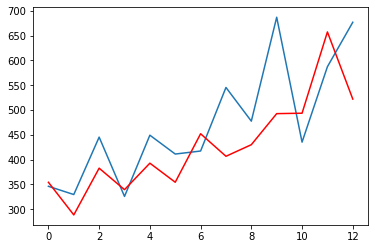

In [10]:
X = series.values
X = np.nan_to_num(X)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast() 
    yhat = output[0] 
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))  
error = mean_squared_error(test, predictions) 
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# RNN 셀 구현

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
tf.random.set_seed(22)
np.random.seed(22)

assert tf.__version__.startswith('2.')

In [3]:
batch_size = 128
total_words = 10000
max_review_len = 80
embedding_len = 100

In [4]:
# imdb.load_data 함수 사용하여 IMDB 데이터셋 다운
# 파라미터 num_words는 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지 사용할지를 의미
# 등장 빈도 순위가 1 ~ 10000에 해당하는 단어만 사용
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words = total_words)

'''
전체 훈련 셋에서 각 샘플의 길이는 서로 다를수 있음
또한 각 문장은 단어 수가 제 각각
모델의 입력으로 사용하려면 모든 샘플 길이를 동일하게 맞추어야함
이를 자연어 처리에서는 패딩작업이라고 함, 보통 숫자 0을 넣어서 길이를 맞춤
케라스에서는 pad_sequence()를 사용
- 첫 번쨰 인자 : 패딩을 진행할 데이터
- maxlen : 모든 데이터에 대해 정규화 할 길이
'''
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen = max_review_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = max_review_len)

'''
넘파이 배열을 Dataset으로 변환
변환하려는 전체 데이터를 메모리로 로딩해야 하므로 큰 용량의 메모리가 필요
메모리 문제 해결책은 Dataset의 from_generator 사용
이것은 필요할 떄만 파이썬 generator을 통해 가져옴
'''
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

'''
train_data.shuffle(10000) : 
- 데이터셋을 임의로 섞음, buffer_size 지정
- 버퍼에서 임의로 샘플 뽑고, 뽑은 샘플은 다른 샘플로 대체
- 데이터셋의 크기에 비해 크거나 같은 버퍼 크기로 지정

bathch()
- 몇 개의 샘플로 가중치를 갱신할지 지정

drop_remainder
- 마지막 배치 크기를 무시하고 지정한 배치 크기 사용
'''
train_data = train_data.shuffle(10000).batch(batch_size, drop_remainder = True)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(batch_size, drop_remainder = True)

print("X_train_shape,", X_train.shape, tf.reduce_max(y_train), tf.reduce_min(y_train))
print("X_test_shape", X_test.shape)

sample = next(iter(test_data))
print(sample[0].shape)

17473536/17464789 [==============================] - 0s 0us/step
X_train_shape, (25000, 80) tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)
X_test_shape (25000, 80)
(128, 80)


In [7]:
# 네트워크(신경망)

# 객체 지향 프로그램 구현
# 구조를 설계한 후 재사용성을 고려하거나 코드의 반복을 최소화 하는데 사용
class RNN_Build(tf.keras.Model):

  # 인스턴스를 생성할 떄 초기화하는 부분
  # init은 객체가 생성될 떄 호출되며, call은 인스턴스가 생성될 떄 호출
  def __init__(self, units):

    # 기반 클래스의 __init__ 호출
    super(RNN_Build, self).__init__()

    # self는 자신의 인스턴스를 의미
    # tf.zeros를 사용하여 0값으로 채워진 텐서를 생성해서 state0에 저장
    self.state0 = [tf.zeros([batch_size, units])]
    self.state1 = [tf.zeros([batch_size, units])]

    '''
    케라스는 텍스트 데이터에 대해 워드 임베딩을 수행하는 임베딩층을 제공
    임베딩층을 사용하려면 각 입력이 모두 정수로 인코딩
    각각 입력은 정수로 변환된 상태에서 임베딩층을 구성
    '''
    # total_words : 텍스트 데이터의 전체 단어 집합 크기, 데이터셋의 단어들이 0부터 20000까지 인코딩 상태면, 단어 집합 크기는 20001
    # embedding_len : 임베딩이 되고 나후 단어의 차원
    # input_length : 입력 데이터 길이
    self.embedding = tf.keras.layers.Embedding(total_words,
                                               embedding_len,
                                               input_length = max_review_len)
    
    # SimpleRNN 셀 클래스
    # units : 출력 공간의 차원
    self.RNNCell0 = tf.keras.layers.SimpleRNNCell(units, dropout = 0.2)
    self.RNNCell1 = tf.keras.layers.SimpleRNNCell(units, dropout = 0.2)
    self.outlayer = tf.keras.layers.Dense(1)

  def call(self, inputs, training = None):
    x = inputs
    x = self.embedding(x)
    state0 = self.state0
    state1 = self.state1

    # 중복된 값이 있을 떄 사용하면 유용
    # 그룹으로 묶은 데이터를 행렬 형태로 전환하여 연산
    for word in tf.unstack(x, axis =1 ):
      out0, state0 = self.RNNCell0(word, state0, training)
      out1, state1 = self.RNNCell0(word, state1, training)
    
    x = self.outlayer(out1)
    prob = tf.sigmoid(x)
    return prob

In [9]:
# 훈련
import time
units = 64
epochs =4

t0 = time.time()
model = RNN_Build(units)
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss = tf.losses.BinaryCrossentropy(),
              metrics = ['acc'],
              experimental_run_tf_function = False)
# validation_freq =2
# 에포크마다 무조건 검증 데이터셋에 대한 계싼을 수행하지 않고 적절한 간격을 두고 계산
model.fit(train_data, epochs = epochs, validation_data = test_data, validation_freq = 2)

Epoch 1/4
195/195 [==============================] - 12s 24ms/step - loss: 0.4991 - acc: 0.7491
Epoch 2/4
195/195 [==============================] - 8s 40ms/step - loss: 0.2968 - acc: 0.8774 - val_loss: 0.3936 - val_acc: 0.8275
Epoch 3/4
195/195 [==============================] - 5s 24ms/step - loss: 0.1940 - acc: 0.9268
Epoch 4/4
195/195 [==============================] - 6s 31ms/step - loss: 0.0913 - acc: 0.9692 - val_loss: 0.5572 - val_acc: 0.8185


In [10]:
# 모델 평가
print("훈련 데이터셋 평가")
(loss, accuracy) = model.evaluate(train_data, verbose = 0)

print("loss = {:.4f}, accuracy : {:.4f}%".format(loss, accuracy * 100))

print("테스트 데이터셋 평가")
(loss, accuracy) = model.evaluate(test_data, verbose = 0)
print("loss = {:.4f}, accuracy : {:.4f}%".format(loss, accuracy * 100))

t1 = time.time()
print('시간:', t1 -t0)

훈련 데이터셋 평가
loss = 0.0324, accuracy : 99.2268%
테스트 데이터셋 평가
loss = 0.5572, accuracy : 81.8470%
시간: 189.80621886253357


In [14]:


class RNN_Build(tf.keras.Model):
    def __init__(self, units):
        super(RNN_Build, self).__init__()
        self.embedding = tf.keras.layers.Embedding(total_words, embedding_len,
                                                   input_length=max_review_len)

        self.rnn = tf.keras.Sequential([
            # SimpleRNN 함수를 사용해 은닉 노드가 다수 개인 RNN 셀 구축가능
            # SimpleRNNCell은 셀이 하나이나 SimpleRNN은 한 번에 셀을 여러개 구축
            # uints : 네트워크의 층 수
            # return_sequences : 마지막 출력 또는 전체 순서를 반환
            # 이떄 주의할점은 이게 True면 출력 순서 중 마지막 값만 출력하는 것이 아니라
            # 전체 순서열을 3차원 텐서 형태로 출력하는 것
            tf.keras.layers.SimpleRNN(units, dropout=0.5, return_sequences=True),
            tf.keras.layers.SimpleRNN(units, dropout=0.5)
        ])
        self.outlayer = tf.keras.layers.Dense(1)

    def call(self, inputs, training=None):
        x = inputs
        x = self.embedding(x)
        x = self.rnn(x)
        x = self.outlayer(x)
        prob = tf.sigmoid(x)

        return prob

In [15]:
# 모델 훈련
import time
units = 64
epochs = 4
t0 = time.time()

model = RNN_Build(units)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

model.fit(train_data, epochs=epochs, validation_data=test_data, validation_freq=2)

Epoch 1/4
195/195 [==============================] - 50s 230ms/step - loss: 0.6542 - accuracy: 0.5776
Epoch 2/4
195/195 [==============================] - 42s 214ms/step - loss: 0.3961 - accuracy: 0.8246 - val_loss: 0.3830 - val_accuracy: 0.8288
Epoch 3/4
195/195 [==============================] - 38s 195ms/step - loss: 0.3004 - accuracy: 0.8771
Epoch 4/4
195/195 [==============================] - 40s 205ms/step - loss: 0.2385 - accuracy: 0.9071 - val_loss: 0.4893 - val_accuracy: 0.8218


In [16]:
print("훈련 데이터셋 평가...")
(loss, accuracy) = model.evaluate(train_data, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))
print("테스트 데이터셋 평가...")
(loss, accuracy) = model.evaluate(test_data, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

t1 = time.time()
print('시간:', t1-t0)

훈련 데이터셋 평가...
loss=0.1151, accuracy: 95.9295%
테스트 데이터셋 평가...
loss=0.4893, accuracy: 82.1835%
시간: 269.837837934494


결과 : simplernncell 보다 훈련 데이터에 대한 정확도 낮아짐, 테스트 셋에 대한 정확도는 조금 높았으나 수행시간이 길어짐
